### 1.0 Importing libraries

In [15]:
import pandas as pd
import numpy as np
import time
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 1.1 Loading Dataset

In [16]:
df = pd.read_csv('datasets/updated_df.csv')

### 2.0 Model Evaluation

In [17]:
X = df.drop(columns=['Habitable', 'Area Name'])
y = df['Habitable']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

models = {
    "LGBM": LGBMClassifier(verbose=-1, n_estimators=100),
    "XGBoost": XGBClassifier(verbosity=0, n_estimators=100, use_label_encoder=False),
    "CatBoost": CatBoostClassifier(verbose=0, n_estimators=100),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100),
    "RandomForest": RandomForestClassifier(n_estimators=100),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=100),
    "LogisticRegression": LogisticRegression(max_iter=5000),
    "NaiveBayes": GaussianNB(),
    "SVM": SVC(kernel='linear', probability=True),
    "LDA": LinearDiscriminantAnalysis(),
    "RidgeClassifier": RidgeClassifier(),
    "DecisionTree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "AdaBoost": AdaBoostClassifier(n_estimators=100)
}

results = []
best_model = None
best_score = 0

for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else 0
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    tt = time.time() - start

    results.append([name, acc, auc, precision, recall, f1, tt])

    if f1 > best_score and f1 != 1.0:
        best_score = f1
        best_model = model
        best_model_name = name
        best_preds = y_pred

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "AUC", "Precision", "Recall", "F1", "Time"])
print(results_df.sort_values(by="F1", ascending=False))

print(f"\nBest Model: {best_model_name}")
print(f"F1 Score: {best_score}")

                 Model  Accuracy       AUC  Precision    Recall        F1  \
0                 LGBM     1.000  1.000000   1.000000  1.000000  1.000000   
2             CatBoost     1.000  1.000000   1.000000  1.000000  1.000000   
3     GradientBoosting     1.000  1.000000   1.000000  1.000000  1.000000   
11        DecisionTree     1.000  1.000000   1.000000  1.000000  1.000000   
13            AdaBoost     1.000  1.000000   1.000000  1.000000  1.000000   
8                  SVM     0.999  1.000000   0.997305  1.000000  0.998650   
1              XGBoost     0.999  1.000000   1.000000  0.997297  0.998647   
4         RandomForest     0.999  1.000000   1.000000  0.997297  0.998647   
6   LogisticRegression     0.998  1.000000   0.994624  1.000000  0.997305   
5           ExtraTrees     0.996  0.999970   0.994595  0.994595  0.994595   
12                 KNN     0.989  0.999472   0.981233  0.989189  0.985195   
7           NaiveBayes     0.895  0.973295   0.867036  0.845946  0.856361   

### 3.0 Result display 

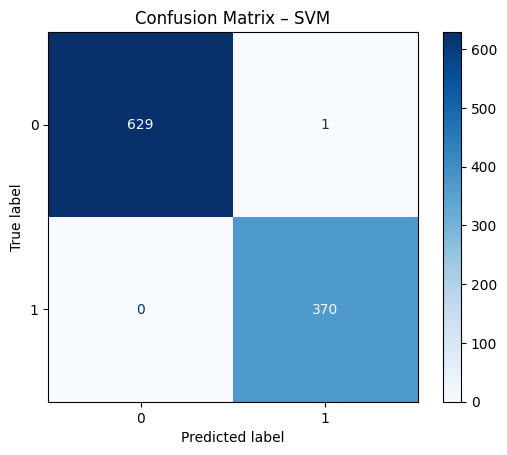

In [18]:
cm = confusion_matrix(y_test, best_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix – {best_model_name}')
plt.show()